### Resampling

zmiana czestotliowsci pomiarow dokonanych aparatura medyczna, aby moc przejrzyscie porowynywac wyniki z danymi z garmina
- dane z aparatury medycznej zapisane byly z czestotliwoscia 500hz
- dane z garmina mierzone byly z czestotliwoscia 128hz

W celu dokonania resamplingu wykorzystana zostala biblioteka scipy.

In [1]:
#przykladowy plik do zaladowania

plik = "Projekt-EKG/data/N36/N36_2025-EKG-2025-11-14-09-48-38.csv"

In [10]:
from scipy.signal import resample, butter, filtfilt, freqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(plik)

garmin_frequency = 128
medical_frequency = 500

number_of_new_samples = int(len(df) * (garmin_frequency/medical_frequency))

resampled_data = resample(df, number_of_new_samples)

resampled_df = pd.DataFrame(resampled_data, columns=df.columns)

In [5]:
df.head()
resampled_df.head()

,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-81.024727,-144.484493,-59.742642,116.635054,-6.820926,-103.001503,4.016550,-35.099015,-97.379231,-107.381399,-121.926628,-80.378538
1,-119.029968,-161.842162,-39.466936,144.386428,-35.356770,-100.845081,21.652168,-77.654614,-53.996939,-77.046685,-105.928544,-65.416441
2,-116.867843,-157.873100,-38.820472,141.385392,-34.937447,-97.561108,24.863827,-57.787308,-62.678416,-83.116885,-107.637352,-64.681384
3,-117.955769,-149.842511,-30.912807,137.562155,-40.212979,-88.575410,30.513801,-67.245139,-54.009079,-76.956986,-107.628247,-60.085766
4,-111.269514,-144.134882,-31.154712,131.016430,-36.795642,-86.332557,29.510261,-56.731512,-59.272013,-82.750748,-115.763831,-67.280741


### Filtering data

W celu usuniecia szumów i nie dokladnosci z sygnalu, zastosujemy dwa filtry:
- lowpass, ktory usunie zaklocenia 
- highpass, ktory wyeliminuje elementy takie jak wlpyw oddechu i dzialania maszyny na wyniki

W celu lepszego zrozumienia jak dziaja te filtry, zaprezentuje kilka rozwiazan.

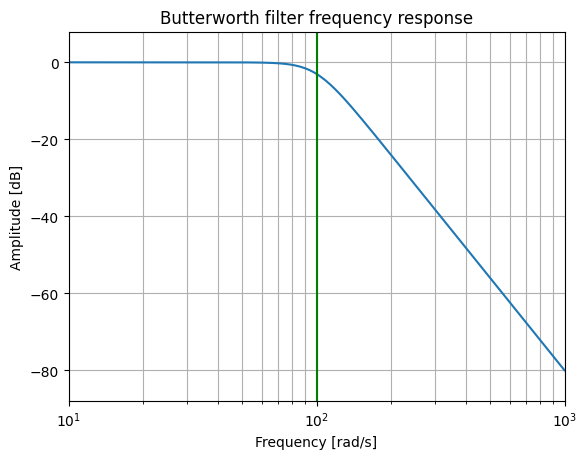

In [14]:
b, a = butter(4, 100, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Do wyznaczenia wartosci kernela filtra buttera, musimy podac maksymalna mozliwa reprezentowalna czestotliwosc, nazywana czestotliwoscia fouriera. Zapewnia ona brak bledow podczas analizowania sygnalu.
- fourier_frequency = max_frequency / 2

In [23]:
def filter_ekg(signal_data, frequency = 128):
    
    """
    calculating needed frequencies
    """
    
    fourier_frequency = frequency/2
    low_cut = 0.5
    high_cut = 40

    normalized_low_cut = low_cut/fourier_frequency
    normalized_high_cut = high_cut/fourier_frequency

    """
    calculating signal nominators and denominator using butter signal
    """

    b,a = butter(N = 4, Wn=[normalized_low_cut, normalized_high_cut], btype='band')

    filtered_data = filtfilt(b, a, signal_data, axis = 0)

    return filtered_data

clean_data_array = filter_ekg(resampled_df)

clean_df = pd.DataFrame(clean_data_array, columns=resampled_df.columns)
clean_df.head()


,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-2.572107,-21.173567,-18.161477,11.866544,8.003869,-20.155859,-13.148471,4.009023,-20.532136,-22.289077,-23.774906,-21.827111
1,-36.013467,-37.310784,-1.169894,36.748093,-16.578124,-19.071676,2.483076,-28.879787,15.085249,2.904588,-9.717072,-9.343757
2,-42.508186,-36.181958,5.093725,39.455885,-23.364591,-14.263119,9.644585,-27.760577,20.068107,7.114343,-6.746694,-3.708096
3,-34.861763,-26.104748,6.600325,30.242375,-20.995866,-7.692305,10.971648,-16.754499,13.400978,2.405263,-11.757705,-4.876113
4,-31.662439,-21.297353,8.779392,25.874421,-20.503904,-4.437021,12.007971,-17.315697,14.578030,1.974934,-16.596925,-9.075072


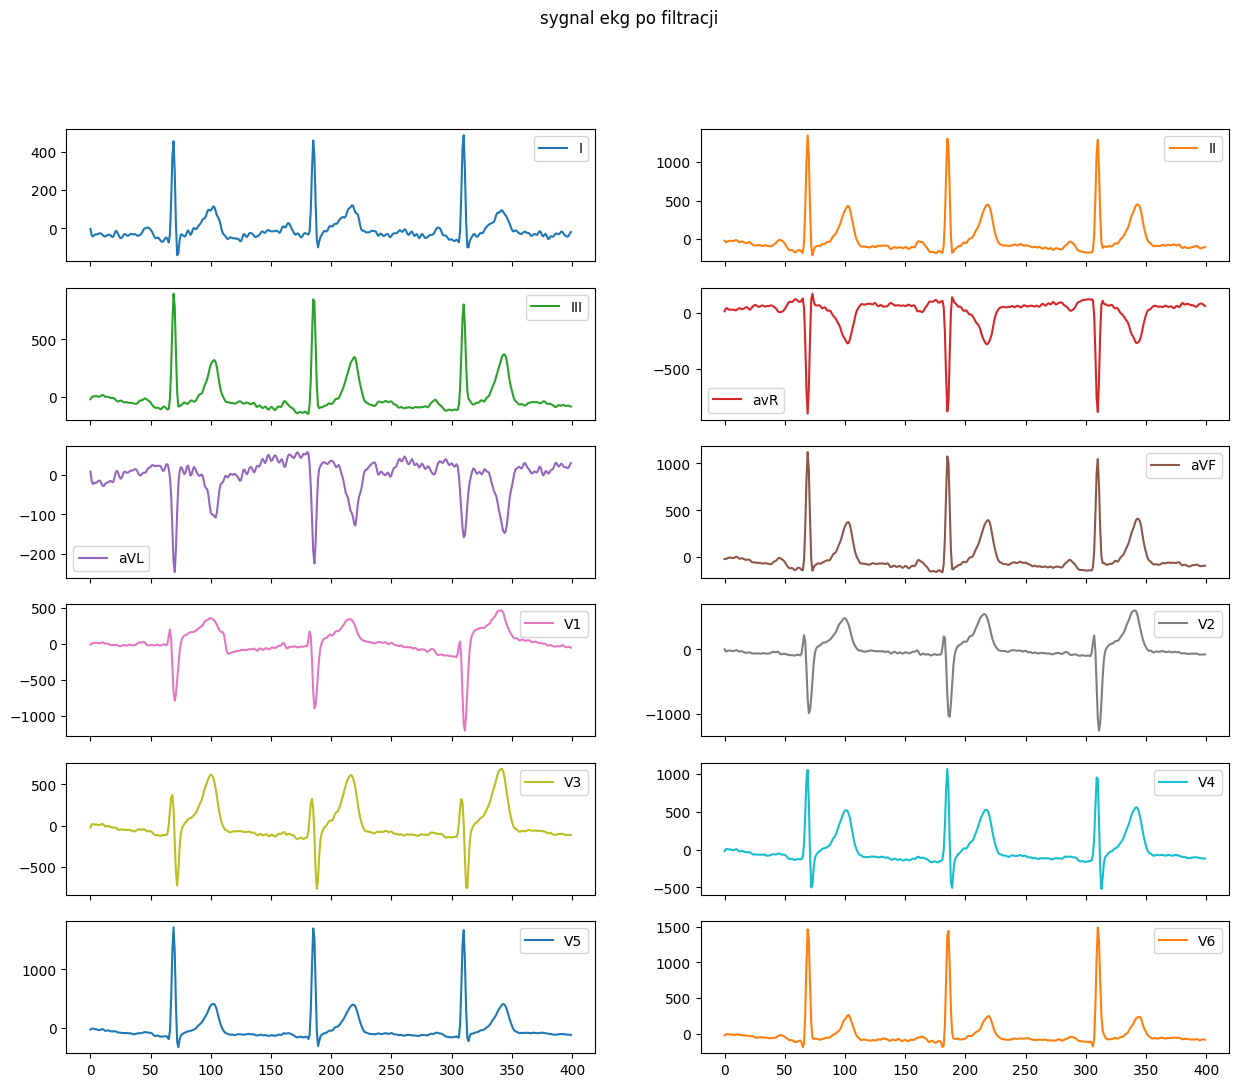

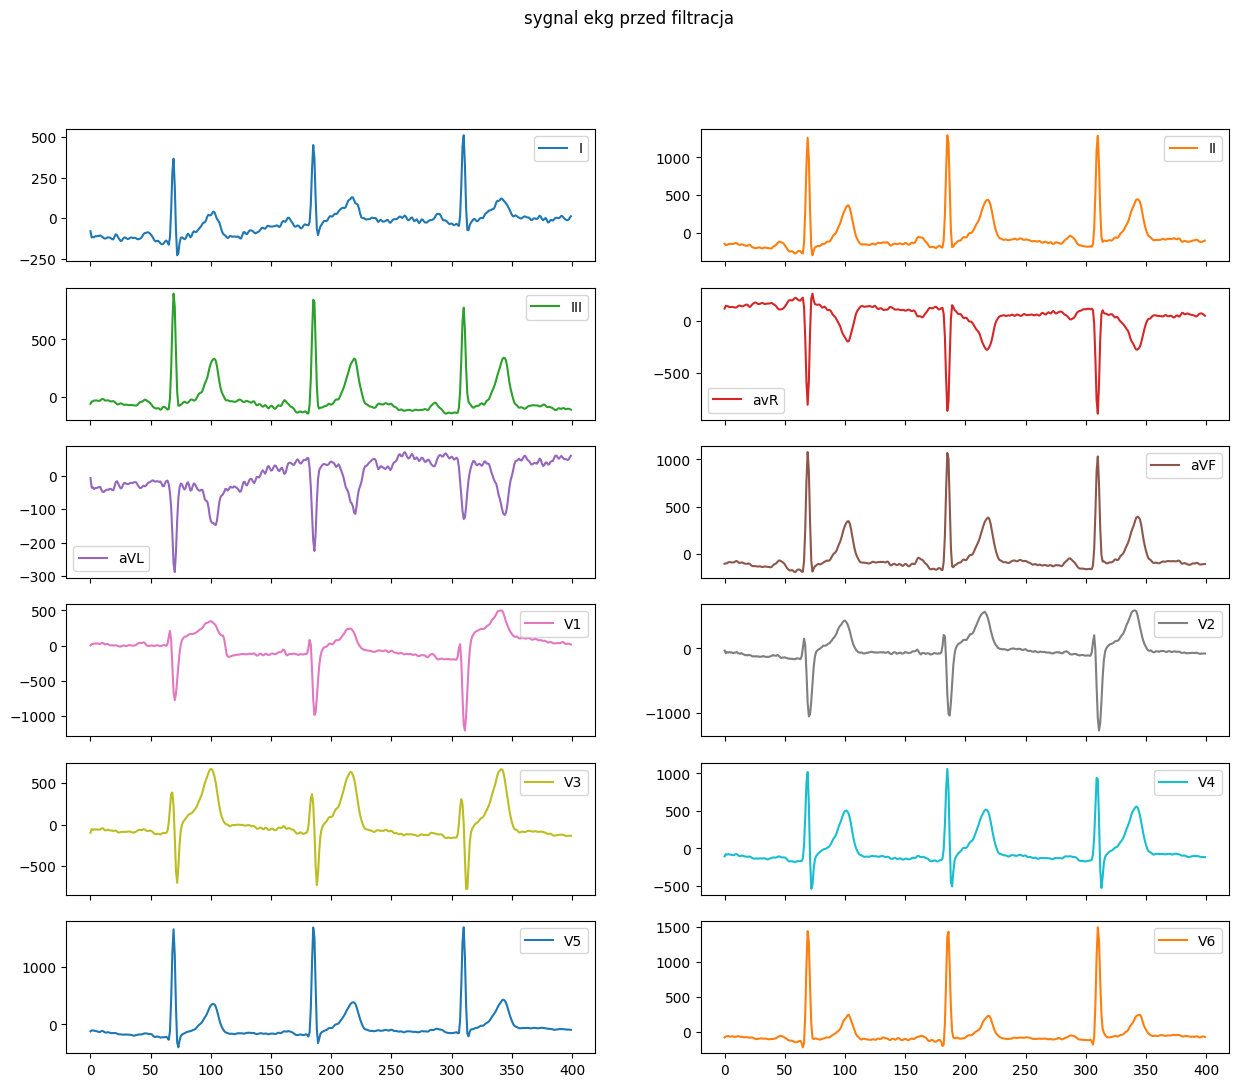

           I         II        III        avR        aVL        aVF  \
0  -2.572107 -21.173567 -18.161477  11.866544   8.003869 -20.155859   
1 -36.013467 -37.310784  -1.169894  36.748093 -16.578124 -19.071676   
2 -42.508186 -36.181958   5.093725  39.455885 -23.364591 -14.263119   
3 -34.861763 -26.104748   6.600325  30.242375 -20.995866  -7.692305   
4 -31.662439 -21.297353   8.779392  25.874421 -20.503904  -4.437021   

          V1         V2         V3         V4         V5         V6  
0 -13.148471   4.009023 -20.532136 -22.289077 -23.774906 -21.827111  
1   2.483076 -28.879787  15.085249   2.904588  -9.717072  -9.343757  
2   9.644585 -27.760577  20.068107   7.114343  -6.746694  -3.708096  
3  10.971648 -16.754499  13.400978   2.405263 -11.757705  -4.876113  
4  12.007971 -17.315697  14.578030   1.974934 -16.596925  -9.075072  
            I          II        III         avR        aVL         aVF  \
0  -81.024727 -144.484493 -59.742642  116.635054  -6.820926 -103.001503   
1 -

In [27]:
subset_clean = clean_df.iloc[:400]
subset_raw = resampled_df[:400]
subset_clean.plot(subplots=True, layout=(6,2), figsize=(15,12), title="sygnal ekg po filtracji")
plt.show()
subset_raw.plot(subplots=True, layout=(6,2), figsize=(15,12), title="sygnal ekg przed filtracja")
plt.show()

print(clean_df.head())
print(resampled_df.head())

